제목 : 약품식별 인공지능 개발을 위한 경구 약제 이미지 분류

목표
1. 이미지 데이터 전처리 및 데이터 확인
2. 이미지 처리기술을 활용하여 경구 약제 이미지 분류

사용 데이터셋

https://aihub.or.kr/aihubdata/data/view.do?currMenu=115&topMenu=100&aihubDataSe=realm&dataSetSn=576

내부의 
ts_81_단일

데이터 분석
단일 알약에 대하여 다양한 각도 광원 등에서 촬영한 사진이 있다.
라벨은 json파일로 주어지며 매우 다양한 데이터들이 존재한다.

관심 데이터

dl_mapping_code : 알약의 고유 id의 역할을 함

(유형 : K-아이디) (예시 : K-111111)

dl_name : 알약의 실제 이름 (유저출력용)  

bbox : 사진 내 알약의 bounding box

예시

![](%EC%A0%9C%EB%AA%A9%20%EC%97%86%EC%9D%8C.png)


데이터 전처리
1. bbox의 좌표 단위로 사진 처리  
PIL의 Image.crop(좌,상,우,하)쓰면될듯
2. 이미지 사이즈 규격화는 1번 단계에서 처리된 이미지들 중 가장 큰 사진을 기준으로

학습 및 검증
꿀벌 과제와 유사하게 구현

파일이 매우 크기 때문에 업로드 하기에는 제한되기에 로컬에서 작업

Day 2
오늘 한일  
1. 데이터 읽어오기
2. 학습모델 빌드
3. 학습시키기
4. 평가

내일 할일
1. 실제 사진 넣어서 잘 분류하는지 확인


전처리 데이터 존재
이미지 로드 완료
['K-038884' 'K-038884' 'K-038884' ... 'K-039147' 'K-039147' 'K-039147']
라벨 로드 완료
딕셔너리 로드 완료
[{'Unnamed: 0': 0, 'K-038884': '에피나레정', 'K-038890': '티아프란정', 'K-038896': '비오메틱스캡슐(바실루스리케니포르미스균)', 'K-038910': '바실리포미스캡슐', 'K-038912': '크라틴정 20mg', 'K-038913': '크라틴정 10mg', 'K-038914': '크라틴정 5mg', 'K-038927': '락토엔큐캡슐(바실루스리케니포르미스균)\xa0', 'K-038929': '아나그레캡슐 0.5mg', 'K-038954': '뮤코원캡슐(에르도스테인)', 'K-038958': '엘도민캡슐 300mg', 'K-038959': '비우미정 500mg/병', 'K-038962': '앤도민300프리미엄연질캡슐 300mg/PTP', 'K-038967': '엘도스인캡슐(에르도스테인)', 'K-038970': '라노펜세미정', 'K-039021': '뉴에르도테캡슐', 'K-039036': '리프레가캡슐 75mg', 'K-039047': '리셀톤캡슐 6.0mg', 'K-039104': '베아로탄정 50mg', 'K-039108': '베아투스정', 'K-039123': '피타로틴정 2mg', 'K-039136': '루키오정10밀리그램(몬테루카스트나트륨)', 'K-039146': '듀카브정30/5밀리그램', 'K-039147': '듀카브정30/10밀리그램'}]
1
9612
9612
Epoch 1/15
58/58 [==============================] - 85s 1s/step - loss: 3.5315 - accuracy: 0.2414 - val_loss: 1.5046 - val_accuracy: 0.4769
Epoch 2/15
58/58 [==============================] -

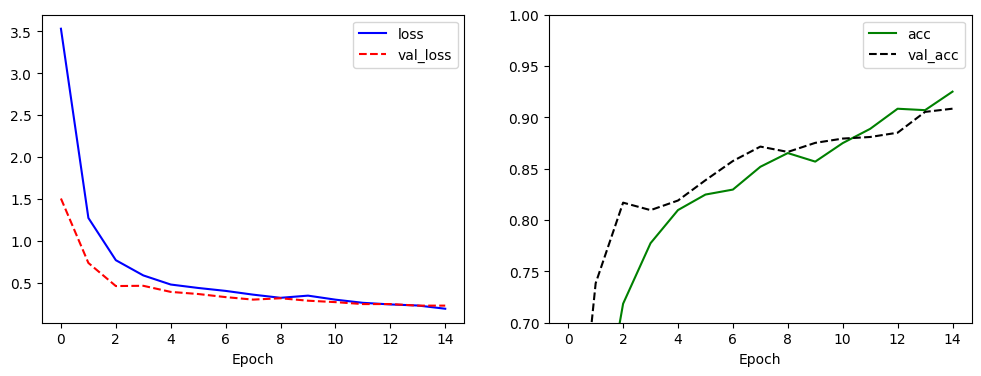

In [119]:
import glob
import json
from PIL import Image
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from keras import Sequential
from keras.layers import Conv2D, MaxPool2D
from keras.layers import Flatten, Dense, Dropout
import keras
import matplotlib.pyplot as plt
imgDir = 'C:/Users/lee/Desktop/swbootcamp/p2/img/TS_81_단일'
labelDir = 'C:/Users/lee/Desktop/swbootcamp/p2/metadata/TL_81_단일'

labelDirs = glob.glob(labelDir+'/**/*.json',recursive=True)

npyDir_img = 'C:/Users/lee/Desktop/swbootcamp/p2/image.npy'
npyDir_label = 'C:/Users/lee/Desktop/swbootcamp/p2/label.npy'
df_dict = 'C:/Users/lee/Desktop/swbootcamp/p2/dict.csv'
#이미지 디렉토리 예시
#C:\Users\lee\Desktop\swbootcamp\p2\img\TS_81_단일\K-038884

'''
id 이름 매핑용 딕셔너리
Key : dl_mapping_code
Value : dl_name
'''
medDict = {}

imgs = []
label_ids=[]
width = 150
height = 150



length = len(labelDirs)
#데이터 로드 및 전처리
if(os.path.isfile(npyDir_img) and os.path.isfile(npyDir_label) and os.path.isfile(df_dict)):
    #전처리는 오래걸리므로 전처리 데이터를 로컬에 보존하며 있으면 로드해서 씀
    print("전처리 데이터 존재")
    imgs=np.load(npyDir_img)
    print("이미지 로드 완료")
    label_ids=np.load(npyDir_label)
    print(label_ids)
    print("라벨 로드 완료")
    medDict = pd.read_csv(df_dict).to_dict('records')
    print("딕셔너리 로드 완료")
    print(medDict)
    label_ids=LabelEncoder().fit_transform(label_ids)

else:
    print("전처리 시작")
    for ldir in labelDirs:
        #print(ldir)
        length = length -1
        print("\r남은수 : ",length,end='')
        with open(ldir,'r',encoding='UTF8') as file:
            data = json.load(file)
            #print(data)
            dl_mapping_code = data['images'][0]['dl_mapping_code']
            file_name = data['images'][0]['file_name']
            dl_name=data['images'][0]['dl_name']

            #print(dl_mapping_code)
            medDict[dl_mapping_code]=dl_name

            bboxCoor = data['annotations'][0]['bbox']
            #print(bboxCoor)
      
            #이미지 디렉토리 접근
            imgDir1=imgDir+'/'+dl_mapping_code+'/'+file_name
            temp = Image.open(imgDir1)
            area = (bboxCoor[0],bboxCoor[1],bboxCoor[0]+bboxCoor[2],bboxCoor[1]+bboxCoor[3])
            croppedImg = temp.crop(area)
            nparrImg = np.array(croppedImg.resize((width,height)).convert('RGB'))
            imgs.append(nparrImg)
            label_ids.append(dl_mapping_code)
            #croppedImg.show()
            file.close()
    imgs=np.array(imgs)
    imgs=imgs/255
    imgs=imgs.reshape(-1,width,height,3)
    np.save(npyDir_img,imgs)
    label_ids = np.array(label_ids)
    np.save(npyDir_label,label_ids)
    label_ids=LabelEncoder().fit_transform(label_ids)

    df=pd.DataFrame(medDict,index=[0])
    df.to_csv(df_dict)  

print(len(imgs))
print(len(label_ids))

#데이터 스플릿
train_X, test_X, train_Y, test_Y = train_test_split(imgs,label_ids,test_size=0.2,random_state=1111)

#모델 빌드
model = Sequential([
    # 특징 추출기 (Feature Extractor)
    Conv2D(input_shape=(width, height, 3), kernel_size=(3, 3), filters=32),
    MaxPool2D(strides=(2, 2)),
    Conv2D(kernel_size=(3, 3), filters=64),
    MaxPool2D(strides=(2, 2)),
    Conv2D(kernel_size=(3, 3), filters=128),
    # 다차원 이미지 => 1차원
    Flatten(),
    # 분류기 (Classifier)
    Dense(units=128, activation='relu'),
    Dropout(rate=0.3),
    Dense(units=len(medDict[0])-1, activation='softmax')
])

model.compile(optimizer=keras.optimizers.Adam(),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_X, train_Y, epochs=15,batch_size=100, validation_split=0.25)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], 'b-', label='loss')
plt.plot(history.history['val_loss'], 'r--', label='val_loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], 'g-', label='acc')
plt.plot(history.history['val_accuracy'], 'k--', label='val_acc')
plt.xlabel('Epoch')
plt.ylim(0.7, 1)
plt.legend()